# 대회 설명

- 해당 Deep Knowledge Tracing(DKT) 대회는 사용자의 과거 문제정답 여부에 따른 다음 문제에 대한 정답 여부를 예측해야한다.
- 사용자별 다음 문제를 맞출지 못맞출지 예측을 해야한다.

In [16]:
import datetime
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as spst

from eda_tool import null_check, nunique, count_plot, kde_hist_plot, extract_datetime, extract_testId, extract_assessmentItemID
from sklearn.metrics import accuracy_score, roc_auc_score
from catboost import CatBoostClassifier
from statsmodels.tsa.seasonal import STL
from statsmodels.api import Logit
from tqdm import tqdm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment',  None)

In [17]:
train_df = pd.read_csv("../data/train_data.csv")
test_df = pd.read_csv("../data/test_data.csv")
train_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


In [18]:
total = pd.concat([train_df, test_df.loc[test_df['answerCode'] != -1]], axis=0)
total = total.sort_values(by=["userID", "Timestamp",]).reset_index(drop=True)
total

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225
...,...,...,...,...,...,...
2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438
2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836
2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836
2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836


## 단변량 분석

### 데이터 설명

- userID : 사용자의 고유번호입니다. 총 7,442명의 고유 사용자가 있으며, train/test셋은 이 userID를 기준으로 90/10의 비율로 나누어졌습니다.
- assessmentItemID : 문항의 고유번호입니다. 총 9,454개의 고유 문항이 있습니다. 이 일련 번호에 대한 규칙은 DKT 2강 EDA에서 다루었으니 강의 들어보시면 좋을 것 같습니다.
- testId : 시험지의 고유번호입니다. 문항과 시험지의 관계는 아래 그림을 참고하여 이해하시면 됩니다. 총 1,537개의 고유한 시험지가 있습니다.
- answerCode : 사용자가 해당 문항을 맞췄는지 여부에 대한 이진 데이터이며 0은 사용자가 해당 문항을 틀린 것, 1은 사용자가 해당 문항을 맞춘 것입니다.
- Timestamp : 사용자가 해당문항을 풀기 시작한 시점의 데이터입니다.
- KnowledgeTag : 문항 당 하나씩 배정되는 태그로, 일종의 중분류 역할을 합니다. 태그 자체의 정보는 비식별화 되어있지만, 문항을 군집화하는데 사용할 수 있습니다. 912개의 고유 태그가 존재합니다.

### 결측치
- train / test의 모든 column에 대해 결측치가 존재하지 않습니다.

In [19]:
null_check(total, total)

[TOTAL] userID's null : 0
[TOTAL] assessmentItemID's null : 0
[TOTAL] testId's null : 0
[TOTAL] answerCode's null : 0
[TOTAL] Timestamp's null : 0
[TOTAL] KnowledgeTag's null : 0


### userID
- train에는 6698, test에는 744명의 유저가 존재합니다.
- 7442명의 유저를 9:1의 비율로 train / test로 나눈 것 입니다.

In [20]:
column = 'userID'
nunique(total, total, column)

[TOTAL] userID's number of unique : 7442


### assessmentItemID
- train에 있는 문제들과 test에 있는 문제들이 정확히 같습니다. (개수, 문제번호 모두 동일)
- 해당 컬럼과 timestamp 컬럼을 이용해 문제별 사용자들의 평균 풀이 시간을 구할 수 있습니다.
- 해당 컬럼과 timestamp 컬럼을 이용해 유저별 평균 문제 풀이 시간을 구할 수 있습니다.
- 해당 컬럼을 이용해 문제별 유저들의 정답 비율을 알 수 있습니다.
- 유저들의 정답 비율은 문제의 난이도를 의미한다고 할 수 있습니다. (정답 비율이 낮으면 난이도가 높은 것이고 문제 풀이시간과 분석을 통해 검증을 해보면 될 것 같습니다.)

In [21]:
column = 'assessmentItemID'
nunique(total, total, column)

[TOTAL] assessmentItemID's number of unique : 9454


### testId
- 문제가 같기 때문에 문제집 또한 모두 동일한 것으로 추측됩니다.
- 해당 컬럼과 assessmentItemID 컬럼을 이용해 시험지 별 평균 맞춘 문제 수를 구할 수 있습니다.
- 시험지 별 평균 맞춘 문제 수는 문제집의 난이도를 의미한다고 추측 가능합니다.

In [22]:
column = 'testId'
nunique(total, total, column)

[TOTAL] testId's number of unique : 1537


### answerCode
- train에는 맞췄는지 (1) 못맞췄는지 (0)에 대한 값만 존재합니다.
- 반면 test에는 맞췄는지 (1) 못맞췄는지 (0)와 더불어 각 유저의 마지막으로 푼 문제의 다음 문제를 나타내는 값(-1)이 존재합니다.

In [23]:
column = 'answerCode'
nunique(total, total, column)

[TOTAL] answerCode's number of unique : 2


### Timestamp
- 각 유저가 각 문제를 풀기 시작한 시간을 나타냅니다.
- 그렇기에 train / test의 고유값 구성이 다른 것이 당연해 보입니다.
- Timestamp를 통해 현재 문제를 풀기 시작한 시간과 다음 문제를 시작한 시간을 이용해 한 문제를 푸는데 걸린 시간을 구할 수 있어보입니다.
- 시계열 관점에서 접근을 한다면 decomposition을 통해 인사이트를 얻을 수 있을 것 같습니다. (decomposition 결과를 피쳐로 사용할 수도 있습니다.)
- 00~12시 사이에 문제를 많이 풀었고, 13~23시 사이에는 그에 비해 문제를 적게 푼 모습이 보입니다.
- 새벽 시간 내내 문제 풀이가 많았던 것을 보아 실제 데이터가 아닌 것 같다는 생각도 듭니다.
- 월별로 봤을 때 차이가 보입니다.

In [24]:
column = 'Timestamp'
nunique(total, total, column)

[TOTAL] Timestamp's number of unique : 2293142


In [25]:
hour_train = total[column].apply(lambda x : x.split(' ')[1][:2].strip())
hour_train = hour_train.to_frame()
hour_train = hour_train.sort_values(by=column)

custom_palette_hour_train = {}

for h, cnt in zip(hour_train.value_counts().index, hour_train.value_counts()):
    h = h[0]
    threshold = 100000
    if threshold < cnt:
        custom_palette_hour_train[h] = 'r'
    else:
        custom_palette_hour_train[h] = 'b'

[TOTAL] Timestamp's number of unique : 24


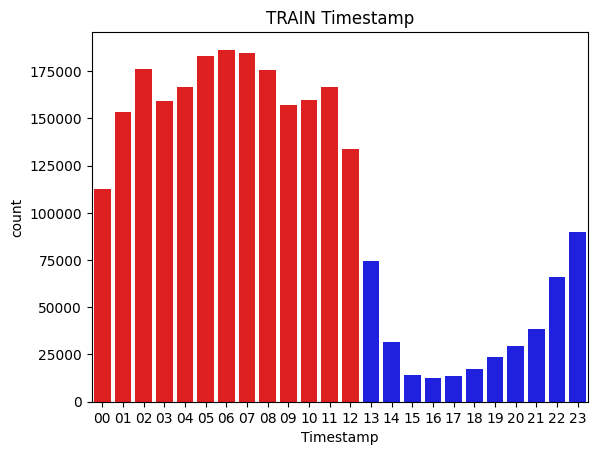

In [26]:
count_plot(hour_train, hour_train, column, custom_palette_hour_train)

In [27]:
month_train = total[column].apply(lambda x : x.split(' ')[0][5:7].strip())
month_train = month_train.to_frame()
month_train = month_train.sort_values(by=column)

custom_palette_month_train = {}

for h, cnt in zip(month_train.value_counts().index, month_train.value_counts()):
    h = h[0]
    threshold = 200000
    if threshold < cnt:
        custom_palette_month_train[h] = 'r'
    else:
        custom_palette_month_train[h] = 'b'

[TOTAL] Timestamp's number of unique : 12


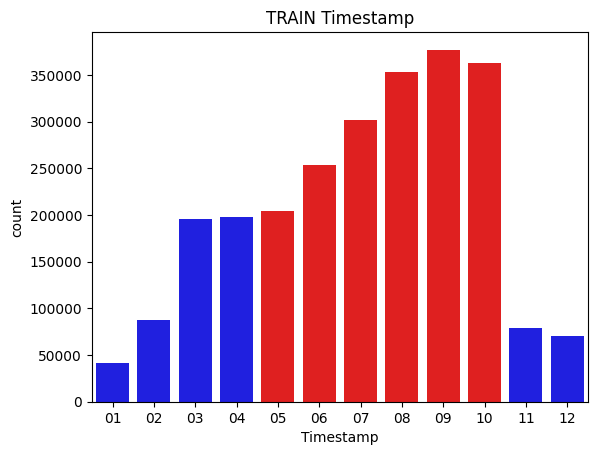

In [28]:
count_plot(month_train, month_train, column, custom_palette_month_train)

### KnowledgeTag
- train / test의 문제가 모두 동일하게 구성되어 있기에 KnowledgeTag도 같은 고유값들을 갖습니다.
- 대회 데이터 설명에 쓰여있듯이 비슷한 유형의 문제를 찾아내기 위해서 클러스터링을 사용할 수 있습니다.

In [29]:
column = 'KnowledgeTag'
nunique(total, total, column)

[TOTAL] KnowledgeTag's number of unique : 912


## 이변량 분석

### userID vs answerCode(target)
- 시각적으로는 유저별로 정답 여부에 대한 차이가 있어보입니다.
- 하지만 카이제곱검정을 통해 확인을 했을 때, 카이제곱검정량이 자유도의 2~3배정도의 수치가 나왔기에 관계가 있다고 볼 수 있습니다.

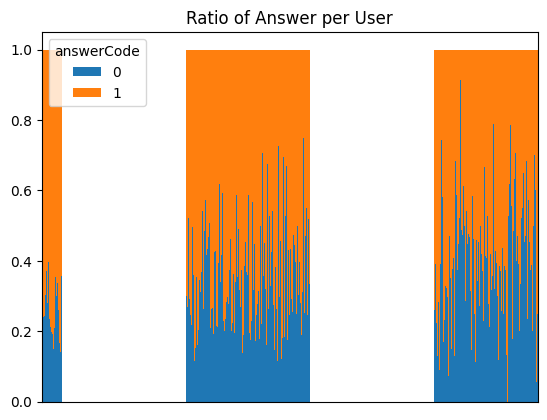

In [30]:
column, target = "userID", "answerCode"

# 유저별 정답비율
ct1 = pd.crosstab(total[column], total[target], normalize="index")
ct2 = pd.crosstab(total[column], total[target])
# print(ct)
ct1.plot.bar(stacked=True)
plt.gca().axes.xaxis.set_visible(False)
plt.title("Ratio of Answer per User")
plt.show()

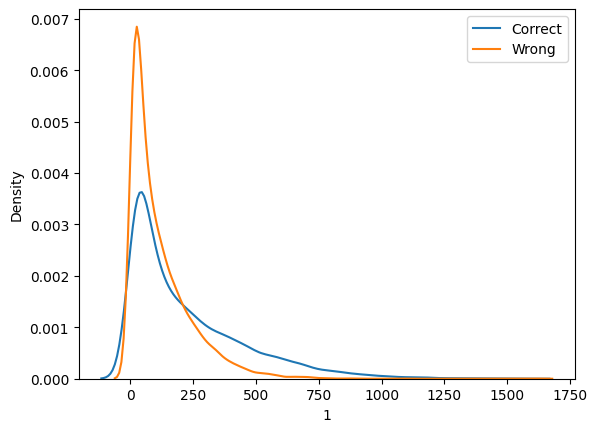

In [36]:
sns.kdeplot(x=1, data=ct2, label="Correct")
sns.kdeplot(x=0, data=ct2, label="Wrong")
plt.legend()
plt.show()

In [37]:
ct2[1].describe().to_frame()

,1
count,7442.000000
mean,222.196721
std,228.817305
min,0.000000
25%,45.000000
50%,141.000000
75%,333.750000
max,1552.000000


In [38]:
result = spst.chi2_contingency(ct2)
print("카이제곱통계량", result[0])
print("p-value", result[1])
print("자유도", result[2])
print("기대빈도\n", result[3])

카이제곱통계량 244772.42072180245
p-value 0.0
자유도 7441
기대빈도
 [[257.29433133 487.70566867]
 [322.22229683 610.77770317]
 [ 95.31977913 180.68022087]
 ...
 [  5.18042278   9.81957722]
 [  5.18042278   9.81957722]
 [  3.10825367   5.89174633]]


### user_answerRatio
- userID를 통해 유저의 정답 비율을 의미하는 user_answerRatio를 만들어 냈습니다.

In [39]:
ct1_dict = {key : val for key, val in zip(ct1[1].keys(), ct1[1].values)}
total['user_answerRatio'] = total['userID'].map(ct1_dict)

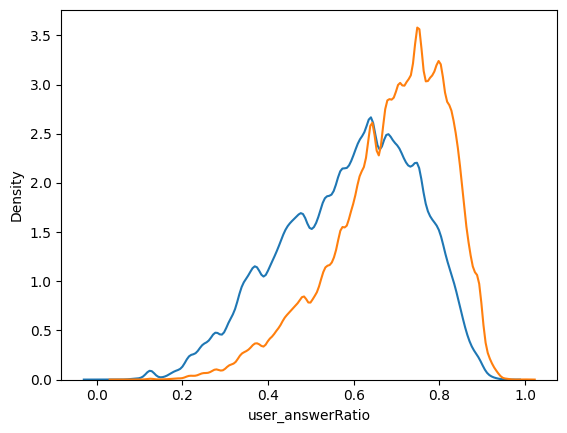

In [40]:
# 시각화 결과를 보면 두 변수가 어느정도 관계가 있습니다.
a0 = total.loc[total['answerCode']==0]
a1 = total.loc[total['answerCode']==1]
sns.kdeplot(x='user_answerRatio', data=a0, label="Wrong")
sns.kdeplot(x='user_answerRatio', data=a1, label="Correct")
plt.show()

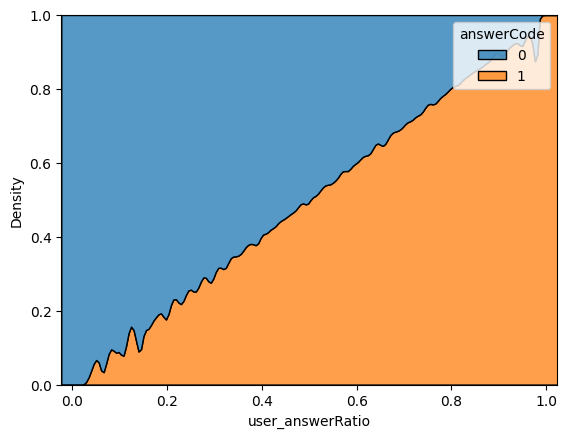

In [42]:
# user_answerRatio가 증가함에 따라 정답의 비율이 올라갑니다. 이것은 당연한 이야기이죠.
# 하지만 user_answerRatio를 유저의 현재까지의 실력이라고 의미를 부여할 수 있을 것 같습니다.
sns.kdeplot(x='user_answerRatio', data=total, hue='answerCode', multiple='fill')
plt.show()

In [43]:
# pvalue가 0.05 이하이므로 두 변수가 어느정도 관련이 있습니다.
model = Logit(total['answerCode'], total['user_answerRatio'])
result = model.fit()
print(result.pvalues)

Optimization terminated successfully.
         Current function value: 0.623956
         Iterations 5
user_answerRatio    0.0
dtype: float64


In [70]:
tmp = total.groupby('userID')['solvingtime'].mean()
user_solvingtime_dict = {key : val for key, val in zip(tmp.keys(), tmp.values)}
total['user_solvingtime_avg'] = total['userID'].map(user_solvingtime_dict)
total

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_answerRatio,assessmentItemCode,testClass,testCode,solvingtime,trend_solvingtime,seasonal_solvingtime,resid_solvingtime,user_solvingtime_avg
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.630872,1,6,1,3,11.093614,0.637499,-8.731113e+00,43.547651
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0.630872,2,6,1,8,13.505966,45.555097,-5.106106e+01,43.547651
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0.630872,3,6,1,7,15.874614,3.981647,-1.285626e+01,43.547651
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0.630872,4,6,1,7,18.198388,-17.703348,6.504960e+00,43.547651
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0.630872,5,6,1,11,20.476724,23.894059,-3.337078e+01,43.547651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,0.555556,5,3,71,60,48.905977,11.094023,-7.105427e-15,52.222222
2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0.555556,1,4,165,11,48.905977,-37.905977,0.000000e+00,52.222222
2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,0.555556,2,4,165,46,48.905977,-2.905977,-7.105427e-15,52.222222
2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,0.555556,3,4,165,73,48.905977,24.094023,7.105427e-15,52.222222


0          NaN
1          1.0
2          2.0
3          3.0
4          4.0
          ... 
2525951    1.0
2525952    1.0
2525953    2.0
2525954    3.0
2525955    4.0
Length: 2525956, dtype: float64

In [164]:
# 유저별 정답 누적합
tmp = total.groupby('userID')['answerCode'].cumsum()
total['user_answer_cumsum_prev'] = tmp.values
total['user_answer_cumsum_prev'] = total['user_answer_cumsum_prev'].fillna(0.0)
user_length = total.groupby(by=["userID"])["assessmentItemID"].agg(len).values
start = 0
for length in np.cumsum(user_length):
    total.iloc[start:length, 15] = total.iloc[start:length, 15].shift(1)
    start = length
total['user_answer_cumsum_prev'] = total['user_answer_cumsum_prev'].fillna(0.0)
total

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_answerRatio,assessmentItemCode,testClass,testCode,solvingtime,trend_solvingtime,seasonal_solvingtime,resid_solvingtime,user_solvingtime_avg,user_answer_cumsum_prev,user_answer_cumcount_prev,user_answerRatio_cum_prev
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.630872,1,6,1,3,11.093614,0.637499,-8.731113e+00,43.547651,0.0,0,0.000000
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0.630872,2,6,1,8,13.505966,45.555097,-5.106106e+01,43.547651,1.0,1,1.000000
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0.630872,3,6,1,7,15.874614,3.981647,-1.285626e+01,43.547651,2.0,2,1.000000
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0.630872,4,6,1,7,18.198388,-17.703348,6.504960e+00,43.547651,3.0,3,1.000000
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0.630872,5,6,1,11,20.476724,23.894059,-3.337078e+01,43.547651,4.0,4,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,0.555556,5,3,71,60,48.905977,11.094023,-7.105427e-15,52.222222,1.0,4,0.250000
2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0.555556,1,4,165,11,48.905977,-37.905977,0.000000e+00,52.222222,1.0,5,0.200000
2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,0.555556,2,4,165,46,48.905977,-2.905977,-7.105427e-15,52.222222,2.0,6,0.333333
2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,0.555556,3,4,165,73,48.905977,24.094023,7.105427e-15,52.222222,3.0,7,0.428571


In [165]:
total.iloc[740:750, [0, -1]]

,userID,user_answerRatio_cum_prev
740,0,0.632432
741,0,0.632928
742,0,0.632075
743,0,0.632571
744,0,0.631720
745,1,inf
746,1,1.000000
747,1,1.000000
748,1,1.000000
749,1,1.000000


In [169]:
# 유저별 문제 수 누적합
# 유저별 특정시점까지의 정답비율 (미래 데이터 포함 x)
tmp = total.groupby('userID')['answerCode'].cumcount()
total['user_answer_cumcount_prev'] = tmp.values
total['user_answerRatio_cum_prev'] = total['user_answer_cumsum_prev'] / total['user_answer_cumcount_prev']
total['user_answerRatio_cum_prev'] = total['user_answerRatio_cum_prev'].fillna(0.0)
total

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_answerRatio,assessmentItemCode,testClass,testCode,solvingtime,trend_solvingtime,seasonal_solvingtime,resid_solvingtime,user_solvingtime_avg,user_answer_cumsum_prev,user_answer_cumcount_prev,user_answerRatio_cum_prev
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.630872,1,6,1,3,11.093614,0.637499,-8.731113e+00,43.547651,0.0,0,0.000000
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0.630872,2,6,1,8,13.505966,45.555097,-5.106106e+01,43.547651,1.0,1,1.000000
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0.630872,3,6,1,7,15.874614,3.981647,-1.285626e+01,43.547651,2.0,2,1.000000
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0.630872,4,6,1,7,18.198388,-17.703348,6.504960e+00,43.547651,3.0,3,1.000000
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0.630872,5,6,1,11,20.476724,23.894059,-3.337078e+01,43.547651,4.0,4,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,0.555556,5,3,71,60,48.905977,11.094023,-7.105427e-15,52.222222,1.0,4,0.250000
2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0.555556,1,4,165,11,48.905977,-37.905977,0.000000e+00,52.222222,1.0,5,0.200000
2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,0.555556,2,4,165,46,48.905977,-2.905977,-7.105427e-15,52.222222,2.0,6,0.333333
2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,0.555556,3,4,165,73,48.905977,24.094023,7.105427e-15,52.222222,3.0,7,0.428571


In [170]:
total.iloc[2525951-10: 2525951]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_answerRatio,assessmentItemCode,testClass,testCode,solvingtime,trend_solvingtime,seasonal_solvingtime,resid_solvingtime,user_solvingtime_avg,user_answer_cumsum_prev,user_answer_cumcount_prev,user_answerRatio_cum_prev
2525941,7440,A030136005,A030000136,0,2020-09-23 09:21:53,7691,0.400000,5,3,136,60,33.807518,26.192482,0.000000e+00,33.733333,5.0,9,0.555556
2525942,7440,A030197001,A030000197,1,2020-10-21 08:31:45,1984,0.400000,1,3,197,61,33.807518,27.192482,7.105427e-15,33.733333,5.0,10,0.500000
2525943,7440,A030197002,A030000197,0,2020-10-21 08:32:46,1984,0.400000,2,3,197,29,33.807518,-4.807518,0.000000e+00,33.733333,6.0,11,0.545455
2525944,7440,A030197003,A030000197,0,2020-10-21 08:33:15,1984,0.400000,3,3,197,2,33.807518,-31.807518,0.000000e+00,33.733333,6.0,12,0.500000
2525945,7440,A030197004,A030000197,0,2020-10-21 08:33:17,1984,0.400000,4,3,197,3,33.807518,-30.807518,0.000000e+00,33.733333,6.0,13,0.461538
2525946,7440,A030197005,A030000197,0,2020-10-21 08:33:20,1984,0.400000,5,3,197,60,33.807518,26.192482,7.105427e-15,33.733333,6.0,14,0.428571
2525947,7441,A030071001,A030000071,0,2020-06-05 06:46:41,438,0.555556,1,3,71,122,48.905977,73.094023,-2.131628e-14,52.222222,0.0,0,0.000000
2525948,7441,A030071002,A030000071,0,2020-06-05 06:48:43,438,0.555556,2,3,71,40,48.905977,-8.905977,-7.105427e-15,52.222222,0.0,1,0.000000
2525949,7441,A030071003,A030000071,1,2020-06-05 06:49:23,438,0.555556,3,3,71,34,48.905977,-14.905977,-7.105427e-15,52.222222,0.0,2,0.000000
2525950,7441,A030071004,A030000071,0,2020-06-05 06:49:57,438,0.555556,4,3,71,24,48.905977,-24.905977,-2.842171e-14,52.222222,1.0,3,0.333333


In [122]:
# 유저별 문제번호별 정답률
tmp = total.groupby(['userID', 'assessmentItemCode'])['answerCode']
tmp.mean()
# total['user_assessmentItemCode_answerRatio'] = 

userID  assessmentItemCode
0       1                     0.817308
        2                     0.769231
        3                     0.653846
        4                     0.692308
        5                     0.553398
                                ...   
7441    1                     0.500000
        2                     0.500000
        3                     1.000000
        4                     0.500000
        5                     0.000000
Name: answerCode, Length: 67036, dtype: float64

### assessmentItemID vs answerCode
- 

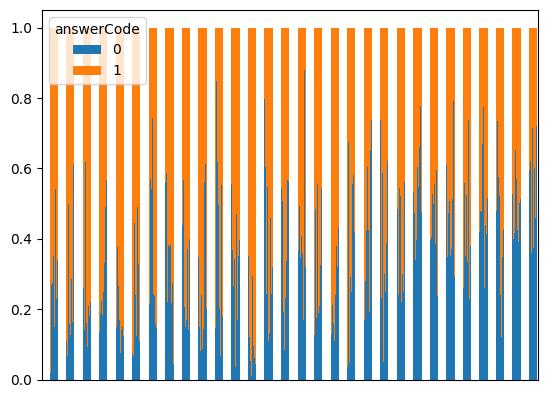

In [44]:
column, target = "assessmentItemID", "answerCode"

# 문제별 정답비율
ct1 = pd.crosstab(total[column], total[target], normalize="index")
ct2 = pd.crosstab(total[column], total[target])
# print(ct)

ct1.plot.bar(stacked=True)
plt.gca().axes.xaxis.set_visible(False)
plt.show()

In [25]:
result = spst.chi2_contingency(ct2)
print("카이제곱통계량", result[0])
print("p-value", result[1])
print("자유도", result[2])
print("기대빈도\n", result[3])

카이제곱통계량 388071.41183004796
p-value 0.0
자유도 9453
기대빈도
 [[109.56203603 207.43796397]
 [109.56203603 207.43796397]
 [109.56203603 207.43796397]
 ...
 [ 15.55297041  29.44702959]
 [ 15.55297041  29.44702959]
 [ 15.55297041  29.44702959]]


#### assessmentItemCode
- assessmentItemID를 통해 assessmentItemCode를 만들었습니다.
- 해당 피쳐와 answerCode간의 plot을 보았을 때, 1~13순으로 난이도라고 예상할 수 있을 것 같습니다.
- 앞쪽에는 쉬운 문제이기에 정답비율이 높고 뒤쪽에는 어려운 문제이기에 정답비율이 낮다는 가정입니다.

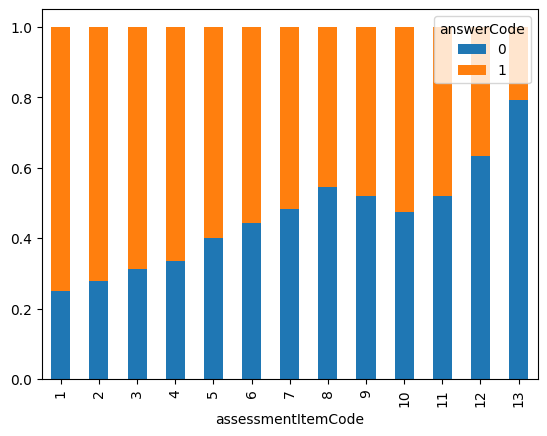

In [45]:
total = extract_assessmentItemID(total)
ct3 = pd.crosstab(total['assessmentItemCode'], total[target], normalize="index")
ct4 = pd.crosstab(total['assessmentItemCode'], total[target])
ct3.plot.bar(stacked=True)
# plt.gca().axes.xaxis.set_visible(False)
plt.show()

In [46]:
result = spst.chi2_contingency(ct4)
print("카이제곱통계량", result[0])
print("p-value", result[1])
print("자유도", result[2])
print("기대빈도\n", result[3])

카이제곱통계량 71540.46532889291
p-value 0.0
자유도 12
기대빈도
 [[1.43100200e+05 2.71248800e+05]
 [1.42805606e+05 2.70690394e+05]
 [1.43063937e+05 2.71180063e+05]
 [1.42295162e+05 2.69722838e+05]
 [1.38706511e+05 2.62920489e+05]
 [7.61183694e+04 1.44283631e+05]
 [4.89950572e+04 9.28709428e+04]
 [2.57556806e+04 4.88203194e+04]
 [7.11168439e+03 1.34803156e+04]
 [2.05144742e+03 3.88855258e+03]
 [1.29441497e+03 2.45358503e+03]
 [9.66666890e+02 1.83233311e+03]
 [1.03263094e+02 1.95736906e+02]]


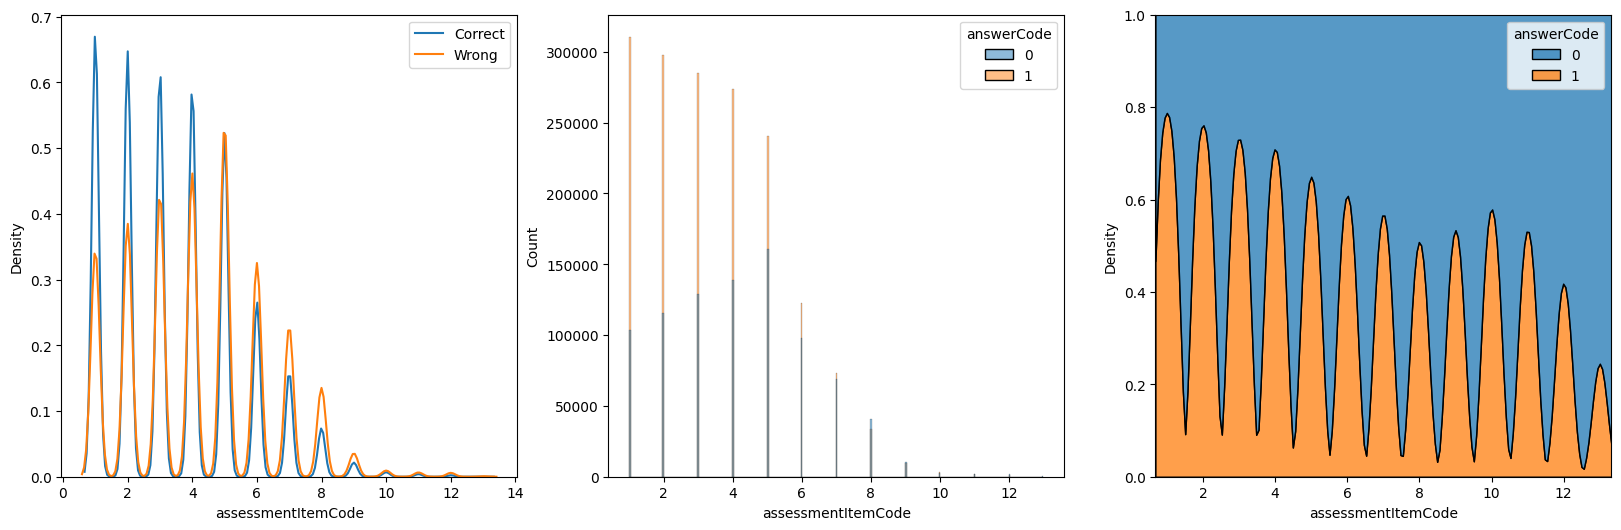

In [47]:
kde_hist_plot(total, 'assessmentItemCode')

### testId vs answerCode
- testId를 그대로 봤을 때도 testId별 정답 비율 차이가 조금은 있어보입니다.

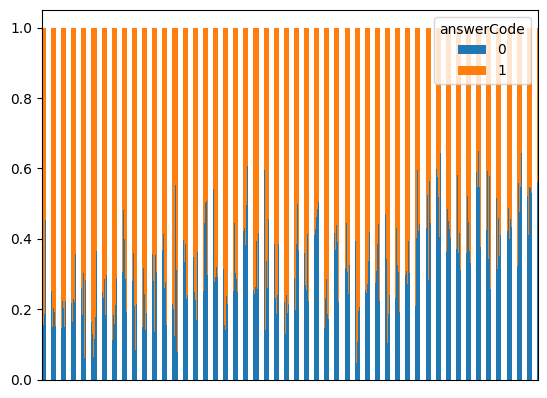

In [48]:
column, target = "testId", "answerCode"

# 문제집별 정답비율
ct1 = pd.crosstab(total[column], total[target], normalize="index")
ct2 = pd.crosstab(total[column], total[target])
# print(ct)

ct1.plot.bar(stacked=True)
plt.gca().axes.xaxis.set_visible(False)
plt.show()

In [49]:
result = spst.chi2_contingency(ct2)
print("카이제곱통계량", result[0])
print("p-value", result[1])
print("자유도", result[2])
print("기대빈도\n", result[3])

카이제곱통계량 231537.77960189848
p-value 0.0
자유도 1536
기대빈도
 [[ 604.3826575  1145.6173425 ]
 [ 604.3826575  1145.6173425 ]
 [ 604.3826575  1145.6173425 ]
 ...
 [ 103.60845557  196.39154443]
 [ 103.60845557  196.39154443]
 [ 102.2270095   193.7729905 ]]


#### testClass & testCode
- testId를 통해 시험지 분류를 위한 testClass를 만들었습니다.
- testId를 통해 testCode를 만들었습니다.
- testClass와 answerCode의 관계를 시각화를 통해 보았을 때, 근소한 차이지만 7~9보다 1~6의 정답 비율이 더 높았습니다.

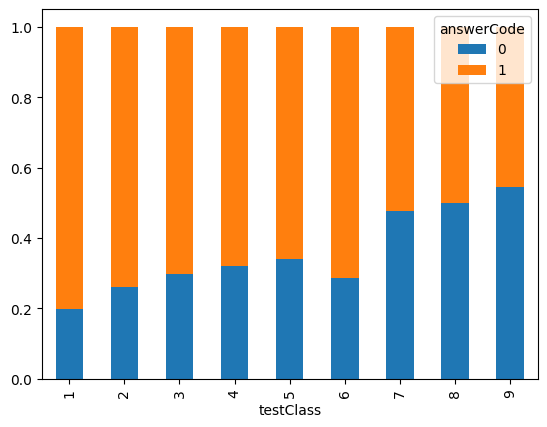

In [50]:
total = extract_testId(total)
ct3 = pd.crosstab(total['testClass'], total[target], normalize="index")
ct4 = pd.crosstab(total['testClass'], total[target])

ct3.plot.bar(stacked=True)
plt.show()

In [51]:
result = spst.chi2_contingency(ct4)
print("카이제곱통계량", result[0])
print("p-value", result[1])
print("자유도", result[2])
print("기대빈도\n", result[3])

카이제곱통계량 122814.12465605553
p-value 0.0
자유도 8
기대빈도
 [[104877.65915162 198797.34084838]
 [102663.20109456 194599.79890544]
 [104770.59708087 198594.40291913]
 [103747.63626286 196655.36373714]
 [105790.10428369 200526.89571631]
 [102325.09216788 193958.90783212]
 [108850.00733821 206326.99266179]
 [ 93883.42056948 177957.57943052]
 [ 45460.28205084  86170.71794916]]


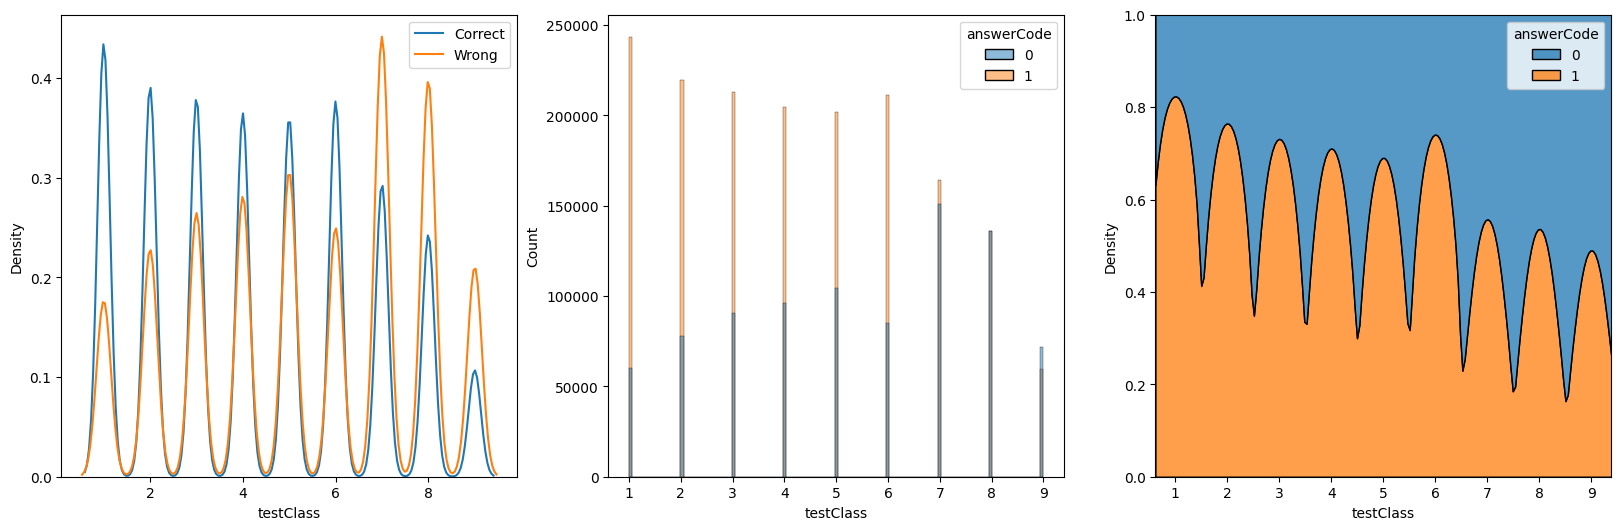

In [61]:
kde_hist_plot(total, 'testClass')

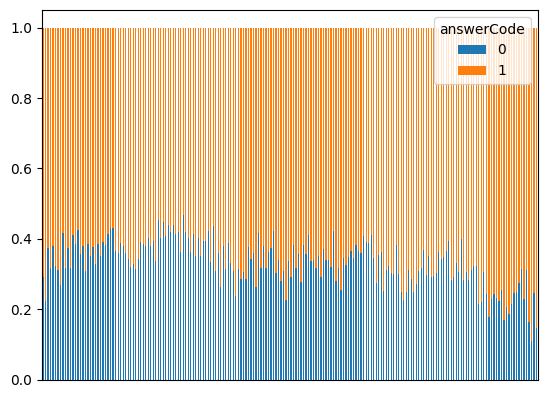

In [52]:
ct5 = pd.crosstab(total['testCode'], total[target], normalize="index")
ct6 = pd.crosstab(total['testCode'], total[target])

ct5.plot.bar(stacked=True)
plt.gca().axes.xaxis.set_visible(False)
plt.show()

In [53]:
result = spst.chi2_contingency(ct6)
print("카이제곱통계량", result[0])
print("p-value", result[1])
print("자유도", result[2])
print("기대빈도\n", result[3])

카이제곱통계량 37059.073138634645
p-value 0.0
자유도 197
기대빈도
 [[ 5784.80543604 10965.19456396]
 [ 4800.52510812  9099.47489188]
 [ 6527.33270097 12372.66729903]
 [ 4731.4528044   8968.5471956 ]
 [ 6285.57963797 11914.42036203]
 [ 4662.38050069  8837.61949931]
 [ 6492.45118759 12306.54881241]
 [ 4904.13356369  9295.86643631]
 [ 6751.81768804 12798.18231196]
 [ 4800.52510812  9099.47489188]
 [ 6561.86885282 12438.13114718]
 [ 4541.50396919  8608.49603081]
 [ 6371.92001761 12078.07998239]
 [ 5335.8354619  10114.1645381 ]
 [ 6337.38386575 12012.61613425]
 [ 5957.48619533 11292.51380467]
 [ 6907.23037139 13092.76962861]
 [ 6423.72424539 12176.27575461]
 [ 6233.77541018 11816.22458982]
 [ 5283.6858726  10015.3141274 ]
 [ 5715.38777081 10833.61222919]
 [ 5473.98006933 10376.01993067]
 [ 5957.14083381 11291.85916619]
 [ 5421.83048002 10277.16951998]
 [ 6181.9711824  11718.0288176 ]
 [ 5422.17584154 10277.82415846]
 [ 5733.00120826 10866.99879174]
 [ 5318.56738597 10081.43261403]
 [ 5733.00120826 10866.

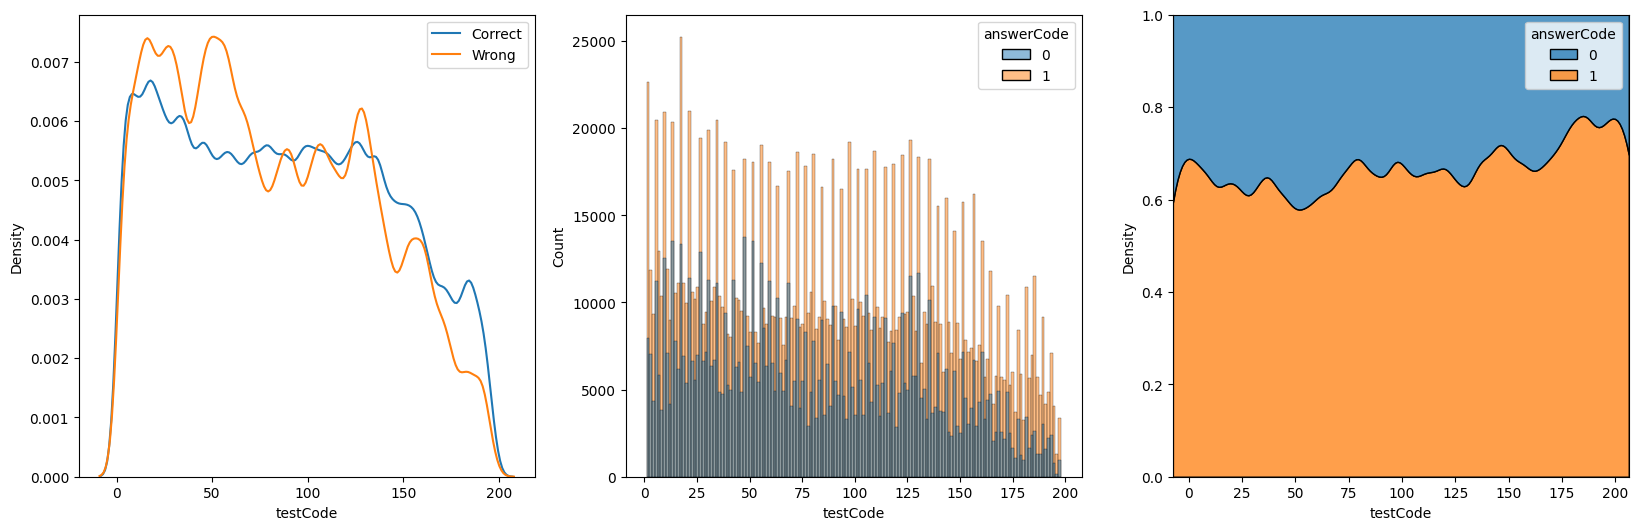

In [62]:
kde_hist_plot(total, 'testCode')

In [54]:
for i in range(1, 10):
    print(f"testClass {i}'s length : {len(total.loc[total['testClass']==i])}")

testClass 1's length : 303675
testClass 2's length : 297263
testClass 3's length : 303365
testClass 4's length : 300403
testClass 5's length : 306317
testClass 6's length : 296284
testClass 7's length : 315177
testClass 8's length : 271841
testClass 9's length : 131631


### Timestamp vs answerCode
- 문제 풀이시간 컬럼을 만들어서 decomposition을 수행했습니다.
- decomposition 결과 값들과 answerCode의 관계를 시각화 했을 때, 풀이시간에 따른 차이가 있어보입니다.

In [55]:
total

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,user_answerRatio,assessmentItemCode,testClass,testCode
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,0.630872,1,6,1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,0.630872,2,6,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,0.630872,3,6,1
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,0.630872,4,6,1
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,0.630872,5,6,1
...,...,...,...,...,...,...,...,...,...,...
2525951,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,0.555556,5,3,71
2525952,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,0.555556,1,4,165
2525953,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,0.555556,2,4,165
2525954,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,0.555556,3,4,165


In [56]:
total['solvingtime'] = 0
solvingtime = np.array([0 for _ in range(len(total))])
trend = np.array([0 for _ in range(len(total))], dtype=float)
seasonal = np.array([0 for _ in range(len(total))], dtype=float)
resid = np.array([0 for _ in range(len(total))], dtype=float)

total_decompose_col = {'trend_solvingtime' : trend,
                       'seasonal_solvingtime' : seasonal,
                       'resid_solvingtime' : resid}

for userid in tqdm(total['userID'].unique()):
    dummy = total.loc[total['userID']==userid].copy()
    dummy['endtime'] = dummy['Timestamp'].shift(-1)
    grouped = dummy.groupby(by=['testId'])
    for key, group in grouped:
        indices = group.index
        group.iloc[-1, -1] = pd.to_datetime(group.iloc[-2, -1]) + datetime.timedelta(seconds=60)
        group['solvingtime'] = pd.to_datetime(group['endtime']) - pd.to_datetime(group['Timestamp'])
        solvingtime[indices] = group['solvingtime'].apply(lambda x : x.seconds if x.seconds < 2000 else 60)
        dummy['solvingtime'][indices] = group['solvingtime'].apply(lambda x : x.seconds if x.seconds < 2000 else 60)

    res = STL(dummy.set_index(dummy['Timestamp'])['solvingtime'], period=3600).fit()
    dummy_indices = dummy.index
    total_decompose_col['trend_solvingtime'][dummy_indices] = res.trend.values
    total_decompose_col['seasonal_solvingtime'][dummy_indices] = res.seasonal.values
    total_decompose_col['resid_solvingtime'][dummy_indices] = res.resid.values

total['solvingtime'] = solvingtime
total = pd.concat([total, pd.DataFrame(total_decompose_col)], axis=1)

100%|██████████| 7442/7442 [19:52<00:00,  6.24it/s] 


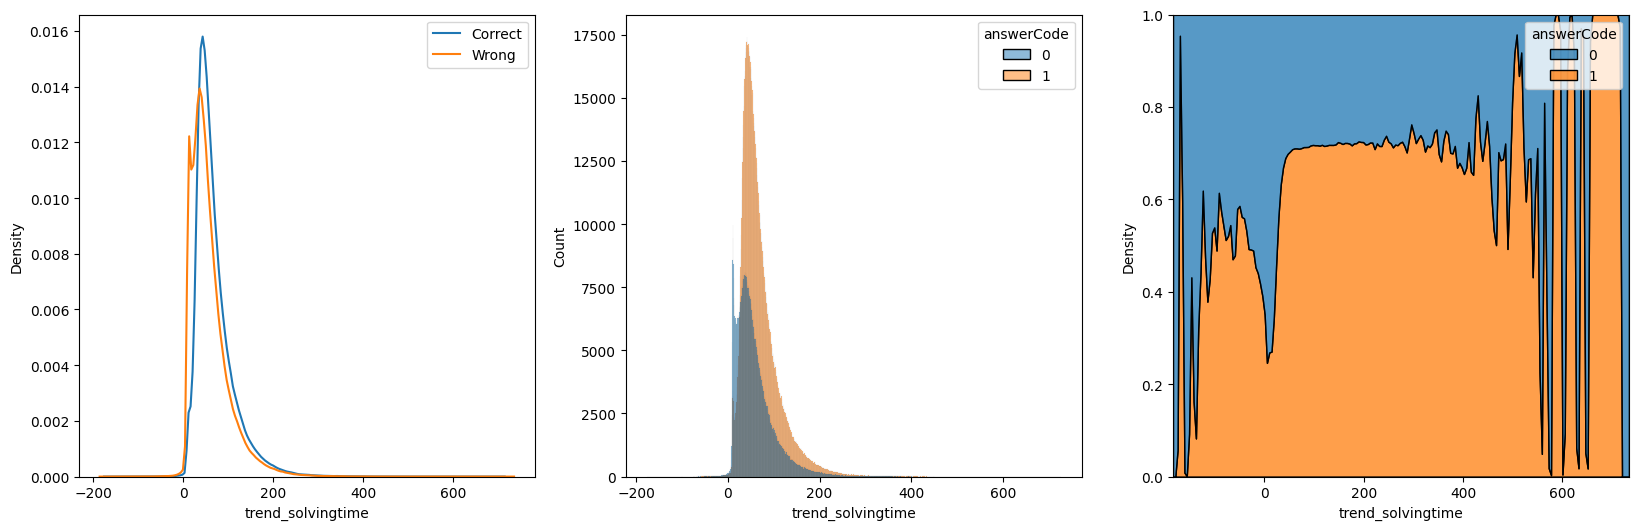

In [57]:
kde_hist_plot(total, 'trend_solvingtime')

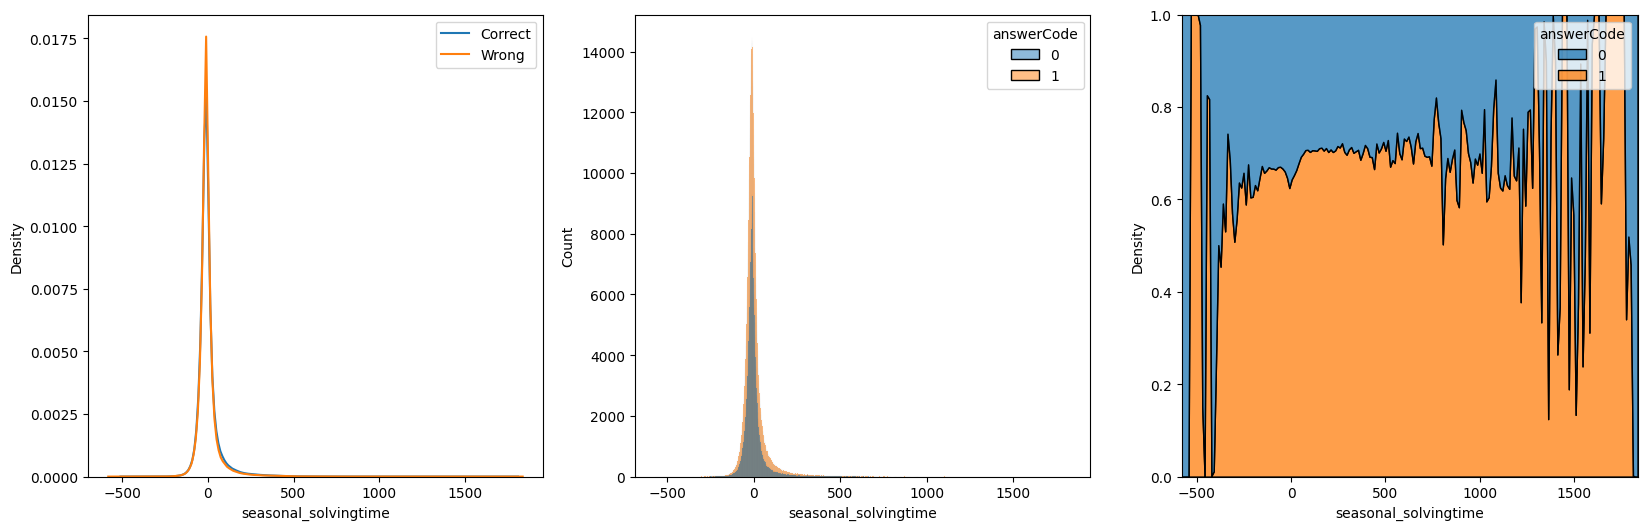

In [58]:
kde_hist_plot(total, 'seasonal_solvingtime')

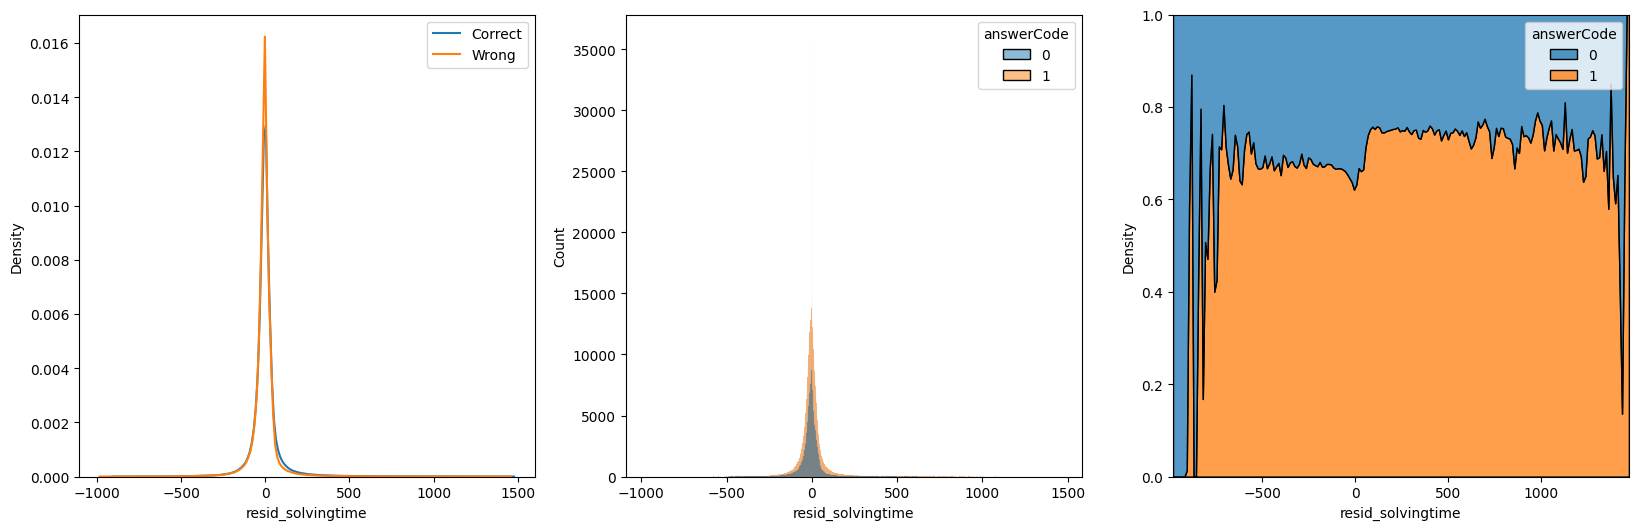

In [59]:
kde_hist_plot(total, 'resid_solvingtime')

### KnowledgeTag vs answerCode
- 

In [60]:
total['KnowledgeTag'].value_counts()

7597    14350
7600    11900
2010    11198
7621    10850
8127     9896
        ...  
2613       50
7125       50
4978       50
2871       50
5142       50
Name: KnowledgeTag, Length: 912, dtype: int64

In [ ]:
test_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag
0,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626
1,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626
2,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625
3,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625
4,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623
...,...,...,...,...,...,...
260109,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832
260110,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832
260111,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244
260112,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244


In [ ]:
# 유저별 문제집별 맞춘 문제수, 해당 문제집 문제수 확인
user_test_answer_ratio = test_df.groupby(by=["userID", "testId"], as_index=False)["assessmentItemID", "answerCode"].agg({"assessmentItemID" : pd.value_counts, "answerCode" : sum})
user_test_answer_ratio['assessmentItemID_cnt'] = user_test_answer_ratio['assessmentItemID'].apply(lambda x: len(x))
user_test_answer_ratio['answer_ratio_per_test'] = user_test_answer_ratio['answerCode'] / user_test_answer_ratio['assessmentItemID_cnt']
user_test_answer_ratio

/tmp/ipykernel_9270/2779260142.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  user_test_answer_ratio = test_df.groupby(by=["userID", "testId"], as_index=False)["assessmentItemID", "answerCode"].agg({"assessmentItemID" : pd.value_counts, "answerCode" : sum})


,userID,testId,assessmentItemID,answerCode,assessmentItemID_cnt,answer_ratio_per_test
0,3,A020000001,"[1, 1, 1, 1, 1]",4,5,0.800000
1,3,A020000005,"[1, 1, 1, 1, 1]",5,5,1.000000
2,3,A020000007,"[1, 1, 1, 1, 1]",5,5,1.000000
3,3,A020000011,"[1, 1, 1, 1, 1]",5,5,1.000000
4,3,A020000013,"[1, 1, 1, 1, 1]",5,5,1.000000
...,...,...,...,...,...,...
42020,7417,A010000107,"[1, 1, 1, 1, 1, 1]",0,6,0.000000
42021,7417,A050000193,"[1, 1, 1, 1]",1,4,0.250000
42022,7439,A040000003,"[1, 1, 1, 1, 1]",4,5,0.800000
42023,7439,A040000130,"[1, 1, 1, 1, 1]",2,5,0.400000


In [ ]:
# 문제집 별 유저들의 평균 정답률
user_test_answer_ratio.groupby(by=["testId"])["answer_ratio_per_test"].mean().to_frame()

,answer_ratio_per_test
testId,
A010000001,0.925000
A010000002,0.953846
A010000003,0.830769
A010000004,0.882927
A010000005,0.813333
...,...
A090000070,0.696429
A090000071,0.425000
A090000072,0.766667


In [199]:
for_test = pd.concat([train_df, test_df], axis=0)
for_test = for_test.sort_values(by=["userID", "Timestamp",]).reset_index(drop=True)
for_test = extract_assessmentItemID(for_test)
for_test = extract_testId(for_test)

for_test['solvingtime'] = 0
solvingtime = np.array([0 for _ in range(len(for_test))])
trend = np.array([0 for _ in range(len(for_test))], dtype=float)
seasonal = np.array([0 for _ in range(len(for_test))], dtype=float)
resid = np.array([0 for _ in range(len(for_test))], dtype=float)

for_test_decompose_col = {'trend_solvingtime' : trend,
                       'seasonal_solvingtime' : seasonal,
                       'resid_solvingtime' : resid}

for userid in tqdm(for_test['userID'].unique()):
    dummy = for_test.loc[for_test['userID']==userid].copy()
    dummy['endtime'] = dummy['Timestamp'].shift(-1)
    grouped = dummy.groupby(by=['testId'])
    for key, group in grouped:
        indices = group.index
        group.iloc[-1, -1] = pd.to_datetime(group.iloc[-2, -1]) + datetime.timedelta(seconds=60)
        group['solvingtime'] = pd.to_datetime(group['endtime']) - pd.to_datetime(group['Timestamp'])
        solvingtime[indices] = group['solvingtime'].apply(lambda x : x.seconds if x.seconds < 2000 else 60)
        dummy['solvingtime'][indices] = group['solvingtime'].apply(lambda x : x.seconds if x.seconds < 2000 else 60)

    res = STL(dummy.set_index(dummy['Timestamp'])['solvingtime'], period=60).fit()
    dummy_indices = dummy.index
    for_test_decompose_col['trend_solvingtime'][dummy_indices] = res.trend.values
    for_test_decompose_col['seasonal_solvingtime'][dummy_indices] = res.seasonal.values
    for_test_decompose_col['resid_solvingtime'][dummy_indices] = res.resid.values

for_test['solvingtime'] = solvingtime
for_test = pd.concat([for_test, pd.DataFrame(for_test_decompose_col)], axis=1)
for_test

100%|██████████| 7442/7442 [22:29<00:00,  5.52it/s] 


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,assessmentItemCode,testClass,testCode,solvingtime,trend_solvingtime,seasonal_solvingtime,resid_solvingtime
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,6,1,3,53.914628,-54.685377,3.770749e+00
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,2,6,1,8,54.018292,-47.133404,1.115112e+00
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,3,6,1,7,54.122052,-30.645419,-1.647663e+01
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4,6,1,7,54.225885,-42.518931,-4.706954e+00
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,5,6,1,11,54.329777,-57.067813,1.373804e+01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,5,3,71,60,29.708316,30.291684,1.065814e-14
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,4,165,11,29.708316,-18.708316,0.000000e+00
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2,4,165,46,29.708316,16.291684,7.105427e-15
2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,3,4,165,73,29.708316,43.291684,0.000000e+00


### train / test split
- 

In [204]:
tmp = for_test.groupby('userID')['solvingtime'].mean()
user_solvingtime_dict = {key : val for key, val in zip(tmp.keys(), tmp.values)}
for_test['user_solvingtime_avg'] = for_test['userID'].map(user_solvingtime_dict)

# 유저별 정답 누적합
tmp = for_test.groupby('userID')['answerCode'].cumsum()
for_test['user_answer_cumsum_prev'] = tmp.values
for_test['user_answer_cumsum_prev'] = for_test['user_answer_cumsum_prev'].fillna(0.0)
user_length = for_test.groupby(by=["userID"])["assessmentItemID"].agg(len).values
start = 0
for length in tqdm(np.cumsum(user_length)):
    for_test.iloc[start:length, 14] = for_test.iloc[start:length, 14].shift(1)
    start = length
for_test['user_answer_cumsum_prev'] = for_test['user_answer_cumsum_prev'].fillna(0.0)

# 유저별 문제 수 누적합
# 유저별 특정시점까지의 정답비율 (미래 데이터 포함 x)
tmp = for_test.groupby('userID')['answerCode'].cumcount()
for_test['user_answer_cumcount_prev'] = tmp.values
for_test['user_answerRatio_cum_prev'] = for_test['user_answer_cumsum_prev'] / for_test['user_answer_cumcount_prev']
for_test['user_answerRatio_cum_prev'] = for_test['user_answerRatio_cum_prev'].fillna(0.0)
for_test

100%|██████████| 7442/7442 [00:02<00:00, 3624.89it/s]


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,assessmentItemCode,testClass,testCode,solvingtime,trend_solvingtime,seasonal_solvingtime,resid_solvingtime,user_solvingtime_avg,user_answer_cumsum_prev,user_answer_cumcount_prev,user_answerRatio_cum_prev
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,6,1,3,53.914628,-54.685377,3.770749e+00,43.547651,0.0,0,0.000000
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,2,6,1,8,54.018292,-47.133404,1.115112e+00,43.547651,1.0,1,1.000000
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,3,6,1,7,54.122052,-30.645419,-1.647663e+01,43.547651,2.0,2,1.000000
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4,6,1,7,54.225885,-42.518931,-4.706954e+00,43.547651,3.0,3,1.000000
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,5,6,1,11,54.329777,-57.067813,1.373804e+01,43.547651,4.0,4,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,5,3,71,60,29.708316,30.291684,1.065814e-14,52.222222,1.0,4,0.250000
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,4,165,11,29.708316,-18.708316,0.000000e+00,52.222222,1.0,5,0.200000
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2,4,165,46,29.708316,16.291684,7.105427e-15,52.222222,2.0,6,0.333333
2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,3,4,165,73,29.708316,43.291684,0.000000e+00,52.222222,3.0,7,0.428571


In [211]:
for_test = extract_datetime(for_test)
train = for_test.loc[for_test['answerCode'] != -1]
test = for_test.loc[for_test['answerCode'] == -1]
train

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,assessmentItemCode,testClass,testCode,solvingtime,...,resid_solvingtime,user_solvingtime_avg,user_answer_cumsum_prev,user_answer_cumcount_prev,user_answerRatio_cum_prev,month,day,hour,minute,second
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,1,6,1,3,...,3.770749e+00,43.547651,0.0,0,0.000000,3,24,0,17,11
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,2,6,1,8,...,1.115112e+00,43.547651,1.0,1,1.000000,3,24,0,17,14
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,3,6,1,7,...,-1.647663e+01,43.547651,2.0,2,1.000000,3,24,0,17,22
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,4,6,1,7,...,-4.706954e+00,43.547651,3.0,3,1.000000,3,24,0,17,29
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,5,6,1,11,...,1.373804e+01,43.547651,4.0,4,1.000000,3,24,0,17,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,5,3,71,60,...,1.065814e-14,52.222222,1.0,4,0.250000,6,5,6,50,21
2526696,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,1,4,165,11,...,0.000000e+00,52.222222,1.0,5,0.200000,8,21,1,6,39
2526697,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,2,4,165,46,...,7.105427e-15,52.222222,2.0,6,0.333333,8,21,1,6,50
2526698,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,3,4,165,73,...,0.000000e+00,52.222222,3.0,7,0.428571,8,21,1,7,36


In [212]:
train.to_csv("new_train.csv", index=False)
test.to_csv("new_test.csv", index=False)